In [1]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.ap-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-9e5e9f8c-d066-4693-9fce-785387bcd8a9',
    'iam_service_endpoint': 'https://iam.au-syd.bluemix.net/oidc/token',
    'api_key': 'y2cJc2kp6oC9-8nRjST7QSpQVfegeT7CQVJ9HgxlH4Xj'
}

configuration_name = 'os_c5c58bffb2ab446da9cecf8e565dad16_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-k9aqgzen9efvfi'))
df_data_1.take(5)

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200519065406-0000
KERNEL_ID = 6e04bda4-9117-4e6f-9444-00042f720311


[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, avg, col, concat, desc, sort_array, asc, min, max, split, udf
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, Normalizer, StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# 1. 处理数据

## 处理缺失值

In [3]:
df_data_1.count()

543705

In [4]:
df = df_data_1.dropna(how = 'any', subset = ['userId', 'sessionId'])
df.count()

543705

In [5]:
df.select('userId').dropDuplicates().sort('userId').show(5)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



- 有些 userId 是空字符串。userId 为空字符串的原因可能有：未注册的用户、未登录账号的用户。

In [6]:
# 去掉 userId 为空字符串的记录
df = df.filter(df['userId'] != '')
df.count()

528005

- 另外，用户在不同的页面上会有不同的记录，比如在听歌的时候会有歌手信息、歌曲时长等，而在访问首页、修改设置的时候不会有歌手信息等记录。所以对于 artist 等字段，值为 None 是合理的，不是缺失值。

## 定义客户流失

创建一列 `Churn` 作为模型的标签。使用 `Cancellation Confirmation` 事件来定义客户流失。

In [7]:
# page 的可能取值
df.groupBy('page').count().collect()

[Row(page='Cancel', count=99),
 Row(page='Submit Downgrade', count=117),
 Row(page='Thumbs Down', count=4911),
 Row(page='Home', count=19089),
 Row(page='Downgrade', count=3811),
 Row(page='Roll Advert', count=7773),
 Row(page='Logout', count=5990),
 Row(page='Save Settings', count=585),
 Row(page='Cancellation Confirmation', count=99),
 Row(page='About', count=1026),
 Row(page='Settings', count=2964),
 Row(page='Add to Playlist', count=12349),
 Row(page='Add Friend', count=8087),
 Row(page='NextSong', count=432877),
 Row(page='Thumbs Up', count=23826),
 Row(page='Help', count=2644),
 Row(page='Upgrade', count=968),
 Row(page='Error', count=503),
 Row(page='Submit Upgrade', count=287)]

In [8]:
# 使用 Cancellation Confirmation 事件来定义客户流失。将有过该操作的用户定义为流失用户。
# 生成流失用户列表
churn_users = df.filter(df['page'] == 'Cancellation Confirmation').select('userId').dropDuplicates()
churn_users_list = [user['userId'] for user in churn_users.collect()]
churn_users_list[:5]

['100010', '200002', '296', '51', '124']

In [9]:
# 增加一列，标记流失，True 代表流失，False 代表没有流失
df_churn = df.withColumn('churn', df['userId'].isin(churn_users_list))
df_churn.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293', churn=True)

In [10]:
# 流失用户占比
churn_users_num = len(churn_users_list)
total_users_num = df_churn.select('userId').dropDuplicates().count()

print('总用户：{} 人，其中流失用户：{} 人，占总用户数的：{:0.1f}%' \
      .format(total_users_num, churn_users_num, 100*churn_users_num/total_users_num))

总用户：448 人，其中流失用户：99 人，占总用户数的：22.1%


## 特征工程
通过对小数据集的探索分析，熟悉了数据。然后，决定选取以下特征，共有12个。
- churn：是否流失，1: 流失，0: 未流失
- gender：性别，1: male，0: female
- has_paid：是否付费（用户等级），1: 有过 paid，0: 全是 free
- friendcount：加好友次数
- playlistcount：加播放列表次数
- advertcount：看到广告次数
- upcount：喜欢的次数
- downcount：不喜欢的次数
- lifetime：注册到最后一次记录的天数
- sessioncount：session 次数
- avg_songs：平均每个 session 听多少首歌
- artistcount：用户听过的歌曲的歌手数量（去重）

In [11]:
f1_churn = df_churn.select('userId', 'churn').dropDuplicates() \
        .replace(['False', 'True'], ['0', '1'], 'churn') \
        .select('userId', col('churn').cast('int'))

f2_gender = df_churn.select('userId', 'gender').dropDuplicates() \
        .replace(['F', 'M'], ['0', '1'], 'gender') \
        .select('userId', col('gender').cast('int'))

f3_friendcount = df_churn.select('userId', 'page') \
        .where(df_churn['page'] == 'Add Friend') \
        .groupBy('userId') \
        .count() \
        .withColumnRenamed('count', 'friendcount')

f4_playlistcount = df_churn.select('userId', 'page') \
        .where(df_churn['page'] == 'Add to Playlist') \
        .groupBy('userId') \
        .count() \
        .withColumnRenamed('count', 'playlistcount')

f5_advertcount = df_churn.select('userId', 'page') \
        .where(df_churn['page'] == 'Roll Advert') \
        .groupBy('userId') \
        .count() \
        .withColumnRenamed('count', 'advertcount')

f6_upcount = df_churn.select('userId', 'page') \
        .where(df_churn['page'] == 'Thumbs Up') \
        .groupBy('userId') \
        .count() \
        .withColumnRenamed('count', 'upcount')

f7_downcount = df_churn.select('userId', 'page') \
        .where(df_churn['page'] == 'Thumbs Down') \
        .groupBy('userId') \
        .count() \
        .withColumnRenamed('count', 'downcount')

f8_lifetime = df_churn.select('userId', 'registration', 'ts') \
        .withColumn('lifetime', (df_churn['ts']-df_churn['registration'])) \
        .groupBy('userId') \
        .agg({'lifetime':'max'}) \
        .withColumnRenamed('max(lifetime)', 'lifetime') \
        .select('userId', (col('lifetime')/(1000*3600*24)).alias('lifetime'))

f9_avgsongs = df_churn.select('userID', 'sessionId', 'page') \
            .filter(df_churn['page'] == 'NextSong') \
            .groupby('userId', 'sessionId') \
            .agg({'page': 'count'}) \
            .groupby('userId') \
            .agg({'count(page)': 'avg'}) \
            .withColumnRenamed('avg(count(page))', 'avgsongs') 

f10_artistcount = df_churn.select('userId', 'artist').dropDuplicates() \
        .filter(df_churn['page'] == 'NextSong') \
        .groupby('userId').count() \
        .withColumnRenamed('count', 'artistcount') \

In [12]:
df_all = f1_churn.join(f2_gender, ['userId']) \
    .join(f3_friendcount, ['userId']) \
    .join(f4_playlistcount, ['userId']) \
    .join(f5_advertcount, ['userId']) \
    .join(f6_upcount, ['userId']) \
    .join(f7_downcount, ['userId']) \
    .join(f8_lifetime, ['userId']) \
    .join(f9_avgsongs, ['userId']) \
    .join(f10_artistcount, ['userId']) \
    .drop('userId') \
    .fillna(0)

df_all.head()

Row(churn=1, gender=0, friendcount=3, playlistcount=1, advertcount=22, upcount=4, downcount=3, lifetime=14.328449074074074, avgsongs=48.0, artistcount=94)

# 2. 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

In [13]:
# 向量化
cols = ['gender', 'friendcount', 'playlistcount', 'advertcount', 
        'upcount', 'downcount', 'lifetime', 'avgsongs', 'artistcount']
assembler = VectorAssembler(inputCols=cols, outputCol='NumFeatures')
data = assembler.transform(df_all)

# 标准化
scaler = StandardScaler(inputCol='NumFeatures', outputCol='features', withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)
data.head()

Row(churn=1, gender=0, friendcount=3, playlistcount=1, advertcount=22, upcount=4, downcount=3, lifetime=14.328449074074074, avgsongs=48.0, artistcount=94, NumFeatures=DenseVector([0.0, 3.0, 1.0, 22.0, 4.0, 3.0, 14.3284, 48.0, 94.0]), features=DenseVector([0.0, 0.1258, 0.0278, 0.9607, 0.0534, 0.2128, 0.3442, 1.4187, 0.1467]))

In [14]:
data_model = data.select(data['churn'].alias('label'), data['features'])
data_model.head()

Row(label=1, features=DenseVector([0.0, 0.1258, 0.0278, 0.9607, 0.0534, 0.2128, 0.3442, 1.4187, 0.1467]))

## 将数据集分成训练集、测试集和验证集

In [15]:
# 训练集：测试集：验证集 = 60%：20%：20%
train, rest = data_model.randomSplit([0.6, 0.4], seed=42)
test, validation = rest.randomSplit([0.5, 0.5], seed=42)

## 建模
在小数据集探索后，这里直接选用 Gradient Boosted Tree 建模。

### Logistic Regression

In [16]:
# 因为流失顾客数据集很小，所以选用 F1 score 作为优化指标。
f1_score = MulticlassClassificationEvaluator(metricName='f1')

In [17]:
gbt = GBTClassifier(seed=42)

# build paramGrid
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[4, 5, 10]) \
    .addGrid(gbt.maxIter,[10, 15]) \
    .build()

crossval_tuned = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid_gbt, evaluator=f1_score, numFolds=3)

In [ ]:
Model_tuned = crossval_tuned.fit(train)
Model_tuned.avgMetrics

[0.7496831011691335,
 0.7456805428082269,
 0.7225740341356527,
 0.7264304380829244,
 0.7054986571568373,
 0.7054986571568373]

In [19]:
# 最好的模型
gbt_best = GBTClassifier(seed=42, maxDepth=4, maxIter=10)
gbt_best_model = gbt_best.fit(train)
gbt_best_result = gbt_best_model.transform(validation)

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print('Best Model:')
print('Accuracy: {}'.format(evaluator.evaluate(gbt_best_result, {evaluator.metricName: 'accuracy'})))
print('F1 Score: {}'.format(evaluator.evaluate(gbt_best_result, {evaluator.metricName: 'f1'})))

Best Model:
Accuracy: 0.7741935483870968
F1 Score: 0.794588969823101


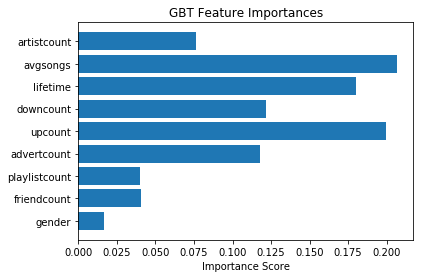

In [20]:
# 特征重要性
importances = gbt_best_model.featureImportances.values
cols = ['gender', 'friendcount', 'playlistcount', 'advertcount', 
        'upcount', 'downcount', 'lifetime', 'avgsongs', 'artistcount']
y = np.arange(len(cols))
 
plt.barh(y, importances, align='center')
plt.yticks(y, cols)
plt.xlabel('Importance Score')
plt.title('GBT Feature Importances');